# Tutorial: Confidence Intervals
By Delaney Granizo-Mackenzie, Jeremiah Johnson, and Gideon Wulfsohn

Part of the Quantopian Lecture Series:

http://www.quantopian.com/lectures

http://github.com/quantopian/research_public

Notebook released under the Creative Commons Attribution 4.0 License.

## Sample Mean vs. Population Mean

Sample means and population means are different. Generally, we want to know about a population mean, but we can only calculate a sample mean. We then want to use the sample mean to estimate the population mean. We use confidence intervals in an attempt to determine how accurately our sample mean estimates the population mean.

## Confidence Interval

If I asked you to estimate the average height of a woman in the USA, you might do this by measuring 10 women and estimating that the mean of that sample was close to the population. Let's try that.

In [1]:
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# We'll set a seed here so our runs are consistent
np.random.seed(10)

# Let's define some 'true' population parameters, we'll pretend we don't know these.
POPULATION_MU = 64
POPULATION_SIGMA = 5

# Generate our sample by drawing from the population distribution
sample_size = 10
heights = np.random.normal(POPULATION_MU, POPULATION_SIGMA, sample_size)
print heights
mean_height = np.mean(heights)
print 'sample mean: ', mean_height

[ 70.65793252  67.57639487  56.27299854  63.95808075  67.10667987
  60.3995722   65.32755793  64.54274263  64.02145715  63.12699895]
sample mean:  64.2990415407


Unfortunately simply reporting the sample mean doesn't do much for us, as we don't know how it relates to the population mean. To get a sense for how it might relate, we can look for how much variance there is in our sample. Higher variance indicates instability and uncertainty.

In [3]:
print 'sample standard deviation: ', np.std(heights)

sample standard deviation:  3.75987801845


This still doesn't do that much for us, to really get a sense of how our sample mean relates to the population mean we need to compute a standard error. The standard error is a measure of the variance of the sample mean.

#### IMPORTANT
Computing a standard error involves assuming that the way you sample is unbaised, and that the data are normal and independent. If these conditions are violated, your standard error will be wrong. There are ways of testing for this and correcting.

The formula for standard error is.

$$SE = \frac{\sigma}{\sqrt{n}}$$

Where $\sigma$ is the sample standard deviation and $n$ is the number of samples.

In [4]:
SE = np.std(heights) / np.sqrt(sample_size)
print 'standard error: ', SE

standard error:  1.18897782627


There is a function in scipy's stats library for calculating the standard error. Note that this function by default contains a degrees-of-freedom correction that is often not necessary (for large enough samples, it is effectively irrelevant). You can omit the correction by setting the parameter ddof to 0.

In [5]:
stats.sem(heights, ddof=0)

1.1889778262717268

Assuming our data are normally distributed, we can use the standard error to compute our confidence interval. To do this we first set our desired confidence level, say 95%, we then determine how many standard deviations contain 95% of the mass. Turns out that the 95% of the mass lies between -1.96 and 1.96 on a standard normal distribution. When the samples are large enough (generally > 30 is taken as a threshold) the Central Limit Theorem applies and normality can be safely assumed; if sample sizes are smaller, a safer approach is to use a $t$-distribution with appropriately specified degrees of freedom. The actual way to compute the values is by using a cumulative distribution function (CDF). If you are not familiar with CDFs, inverse CDFs, and their companion PDFs, you can read about them [here](https://en.wikipedia.org/wiki/Probability_density_function) and [here](https://en.wikipedia.org/wiki/Cumulative_distribution_function). Look [here](https://en.wikipedia.org/wiki/Student%27s_t-distribution) for information on the $t$-distribution. We can check the 95% number using one of the Python functions. 

NOTE: Be careful when applying the Central Limit Theorem, however, as many datasets in finance are fundamentally non-normal and it is not safe to apply the theorem casually or without attention to subtlety.

We can visualize the 95% mass bounds here.

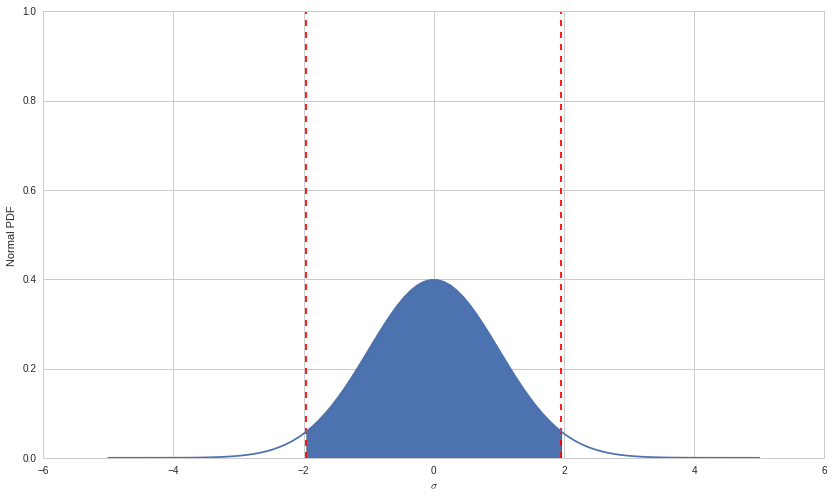

In [6]:
# Set up the x axis
x = np.linspace(-5,5,100)
# Here's the normal distribution
y = stats.norm.pdf(x,0,1)
plt.plot(x,y)

# Plot our bounds
plt.vlines(-1.96, 0, 1, colors='r', linestyles='dashed')
plt.vlines(1.96, 0, 1, colors='r', linestyles='dashed')

# Shade the area
fill_x = np.linspace(-1.96, 1.96, 500)
fill_y = stats.norm.pdf(fill_x, 0, 1)
plt.fill_between(fill_x, fill_y)

plt.xlabel('$\sigma$')
plt.ylabel('Normal PDF');

### Here's the trick

Now, rather than reporting our sample mean without any sense of the probability of it being correct, we can compute an interval and be much more confident that the population mean lies in that interval. To do this we take our sample mean $\mu$ and report $\left(\mu-1.96 SE , \mu+1.96SE\right)$.

This works because assuming normality, that interval will contain the population mean 95% of the time.

### SUBTLETY:
In any given case, the true value of the estimate and the bounds of the confidence interval are fixed. It is incorrect to say that "The national mean female height is between 63 and 65 inches with 95% probability," but unfortunately this is a very common misinterpretation. Rather, the 95% refers instead to the fact that over many computations of a 95% confidence interval, the true value will be in the interval in 95% of the cases (assuming correct calibration of the confidence interval, which we will discuss later). But in fact for a single sample and the single confidence interval computed from it, we have no way of assessing the probability that the interval contains the population mean. The visualization below demonstrates this. 

In the code block below, there are two things to note. First, although the sample size is sufficiently large to assume normality, we're using a $t$-distribution, just to demonstrate how it is used. Second, the $t$-values needed (analogous to the $\pm1.96$ used above) are being calculated from the inverted cumulative density function, the ppf in scipy.stats. The $t$-distribution requires the extra parameter degrees of freedom (d.o.f), which is the size of the sample minus one. 

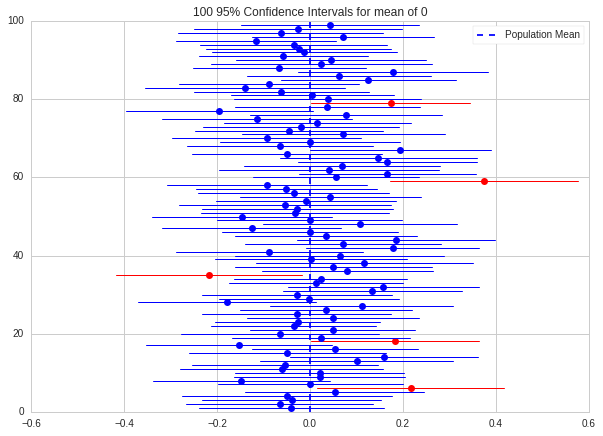

In [7]:
np.random.seed(8309)
n = 100 # number of samples to take
samples = [np.random.normal(loc=0, scale=1, size=100) for _ in range(n)]

fig, ax = plt.subplots(figsize=(10, 7))
for i in np.arange(1, n, 1):
    sample_mean = np.mean(samples[i])  # calculate sample mean
    se = stats.sem(samples[i])  # calculate sample standard error
    h = se*stats.t.ppf((1+0.95)/2, len(samples[i])-1) # calculate t; 2nd param is d.o.f. 
    sample_ci = [sample_mean - h, sample_mean + h]
    if ((sample_ci[0] <= 0) and (0 <= sample_ci[1])):
        plt.plot((sample_ci[0], sample_ci[1]), (i, i), color='blue', linewidth=1);
        plt.plot(np.mean(samples[i]), i, 'bo');
    else:
        plt.plot((sample_ci[0], sample_ci[1]), (i, i), color='red', linewidth=1);
        plt.plot(np.mean(samples[i]), i, 'ro');
plt.axvline(x=0, ymin=0, ymax=1, linestyle='--', label = 'Population Mean');
plt.legend(loc='best');
plt.title('100 95% Confidence Intervals for mean of 0');

### Further Reading

This is only a brief introduction, Wikipedia has excellent articles detailing these subjects in greater depth. Let's go back to our heights example. Since the sample size is small, we'll use a $t$-test.

In [8]:
# standard error SE was already calculated
t_val = stats.t.ppf((1+0.95)/2, 9)  # d.o.f. = 10 - 1
print 'sample mean height:', mean_height
print 't-value:', t_val
print 'standard error:', SE
print 'confidence interval:', (mean_height - t_val * SE, mean_height + t_val * SE)

sample mean height: 64.2990415407
t-value: 2.26215716274
standard error: 1.18897782627
confidence interval: (61.609386834663141, 66.988696246744738)


There is a built-in function in scipy.stats for computing the interval. Remember to specify the degrees of freedom.

In [9]:
print '99% confidence interval:', stats.t.interval(0.99, df=9,
                                                   loc=mean_height, scale=SE)
print '95% confidence interval:', stats.t.interval(0.95, df = 9, 
                                                   loc=mean_height, scale=SE)
print '80% confidence interval:', stats.t.interval(0.8, df = 9, 
                                                   loc=mean_height, scale=SE)

99% confidence interval: (60.43505913983995, 68.163023941567928)
95% confidence interval: (61.609386834663141, 66.988696246744738)
80% confidence interval: (62.654651037653949, 65.94343204375393)


Note that as your confidence increases, the interval necessarily widens.

Assuming normality, there's also a built in function that will compute our interval for us. This time you don't need to specify the degrees of freedom. Note that at a corresponding level of confidence, the interval calculated using the normal distribution is narrower than the interval calcuated using the $t$-distribution.

In [10]:
print stats.norm.interval(0.99, loc=mean_height, scale=SE)
print stats.norm.interval(0.95, loc=mean_height, scale=SE)
print stats.norm.interval(0.80, loc=mean_height, scale=SE)

(61.236437614523354, 67.361645466884525)
(61.968687822794635, 66.629395258613243)
(62.775305146047593, 65.822777935360293)


## What does this mean?

Confidence intervals allow us to set our desired confidence, and then report a range that will likely contain the population mean. The higher our desired confidence, the larger range we report. In general, one can never report a single point value, because the probability that any given point is the true population mean is incredibly small. Let's see how our intervals tighten as we change sample size.

In [11]:
np.random.seed(10)

sample_sizes = [10, 100, 1000]
for s in sample_sizes:
    heights = np.random.normal(POPULATION_MU, POPULATION_SIGMA, s)
    SE = np.std(heights) / np.sqrt(s)
    print stats.norm.interval(0.95, loc=mean_height, scale=SE)

(61.968687822794635, 66.629395258613243)
(63.343692029946574, 65.254391051461297)
(64.00593339807287, 64.592149683335009)


## Visualizing Confidence Intervals

Here is some code to visualize a confidence interval on a graph. Feel free to play around with it.

(63.588854219913536, 65.573463595434731)


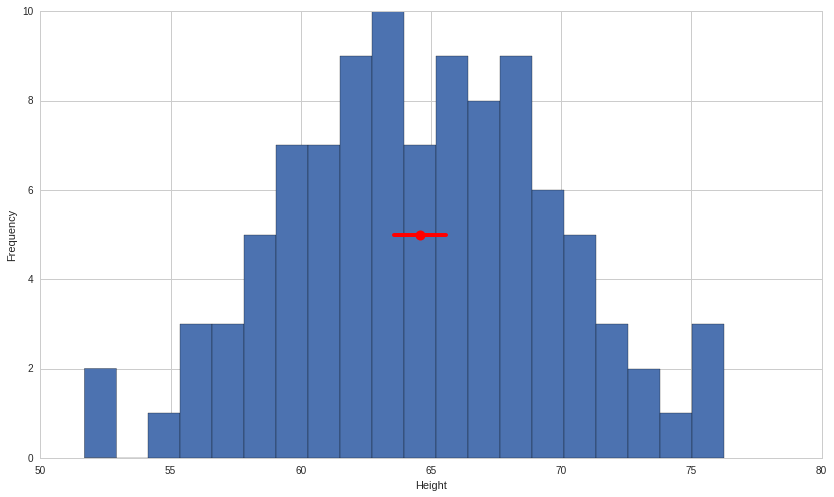

In [12]:
sample_size = 100
heights = np.random.normal(POPULATION_MU, POPULATION_SIGMA, sample_size)
SE = np.std(heights) / np.sqrt(sample_size)
(l, u) = stats.norm.interval(0.95, loc=np.mean(heights), scale=SE)

print (l, u)

plt.hist(heights, bins=20)
plt.xlabel('Height')
plt.ylabel('Frequency')

# Just for plotting
y_height = 5
plt.plot([l, u], [y_height, y_height], '-', color='r', linewidth=4, label='Confidence Interval')
plt.plot(np.mean(heights), y_height, 'o', color='r', markersize=10);

## Miscalibration and Violation of Assumptions

The computation of a standard deviation, standard error, and confidence interval all rely on certain assumptions. If these assumptions are violated then the 95% confidence interval will not necessarily contain the population parameter 95% of the time. We say that in this case the confidence interval is miscalibrated. Here is an example.

### Example: Autocorrelated Data

If your data generating process is autocorrelated, then estimates of standard deviation will be wrong. This is because autocorrelated processes tend to produce more extreme values than normally distributed processes. This is due to new values being dependent on previous values, series that are already far from the mean are likely to stay far from the mean. To check this we'll generate some autocorrelated data according to the following process.

$$X_t = \theta X_{t-1} + \epsilon$$
$$\epsilon \sim \mathcal{N}(0,1)$$

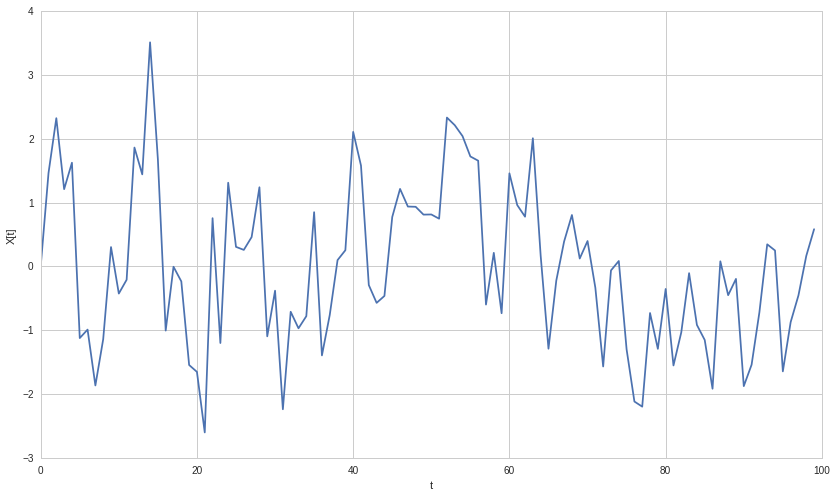

In [13]:
def generate_autocorrelated_data(theta, mu, sigma, N):
    # Initialize the array
    X = np.zeros((N, 1))
    
    for t in range(1, N):
        # X_t = theta * X_{t-1} + epsilon
        X[t] = theta * X[t-1] + np.random.normal(mu, sigma)
    return X

X = generate_autocorrelated_data(0.5, 0, 1, 100)

plt.plot(X);
plt.xlabel('t');
plt.ylabel('X[t]');

It turns out that for larger sample sizes, you should see the sample mean asymptotically converge to zero. This is because the process is still centered around zero, but let's check if that's true. We'll vary the number of samples drawn, and look for convergence as we increase sample size.

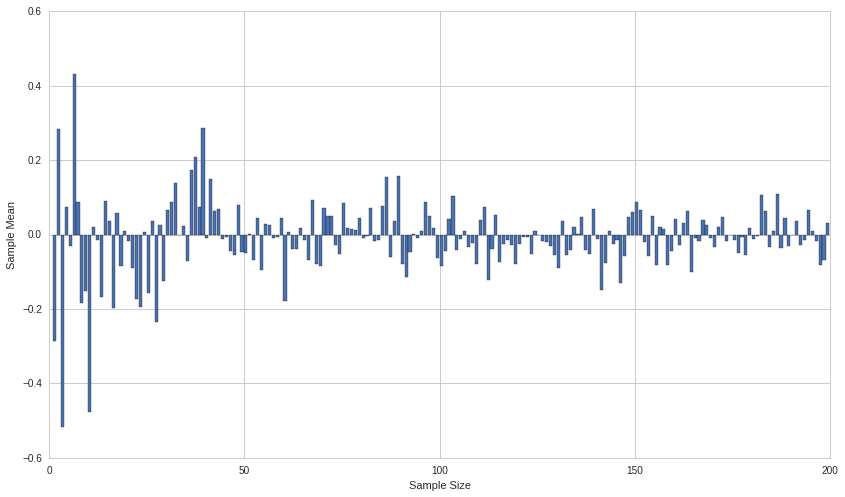

In [14]:
sample_means = np.zeros(200-1)
for i in range(1, 200):
    X = generate_autocorrelated_data(0.5, 0, 1, i * 10)
    sample_means[i-1] = np.mean(X)
    
plt.bar(range(1, 200), sample_means);
plt.xlabel('Sample Size');
plt.ylabel('Sample Mean');

Definitely looks like there's some convergence, we can also check what the mean of the sample means is.

In [15]:
np.mean(sample_means)

-0.0085719962029766478

Pretty close to zero. We could also derive symbolically that the mean is zero, but let's assume that we've convinced ourselves with the simple empiral analysis. Now that we know the population mean, we can check the calibration of confidence intervals. First we'll write two helper functions which compute a naive interval for some input data, and check whether the interval contains the true mean, 0.

In [16]:
def compute_unadjusted_interval(X):
    T = len(X)
    # Compute mu and sigma MLE
    mu = np.mean(X)
    sigma = np.std(X)
    SE = sigma / np.sqrt(T)
    # Compute the bounds
    return stats.norm.interval(0.95, loc=mu, scale=SE)

# We'll make a function that returns true when the computed bounds contain 0
def check_unadjusted_coverage(X):
    l, u = compute_unadjusted_interval(X)
    # Check to make sure l <= 0 <= u
    if l <= 0 and u >= 0:
        return True
    else:
        return False

Now we'll run many trials, in each we'll sample some data, compute a confidence interval, and then check if the confidence interval contains the population mean. We'll keep a running tally, and we should expect to see 95% of the trials succeed if the intervals are calibrated correctly.

In [17]:
T = 100
trials = 500
times_correct = 0
for i in range(trials):
    X = generate_autocorrelated_data(0.5, 0, 1, T)
    if check_unadjusted_coverage(X):
        times_correct += 1
    
print 'Empirical Coverage: ', times_correct/float(trials)
print 'Expected Coverage: ', 0.95

Empirical Coverage:  0.732
Expected Coverage:  0.95


Clearly the coverage is wrong. In this case we'd need to do what's known as a Newey-West correction on our standard error estimate to account for the autocorrelation. In practice it's important to check for the assumptions you make. It is quick and easy to check if your data are stationary (which implies not autocorrelated), and it can save you a lot of pain and suffering to do so. A normality test such as `Jarque Bera` will also be a good idea, as it may detect certain distribution properties which may violate assumptions of many following statistical analyses.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*